This kernel is inspired by Chau Ngoc Huynh's kernel (3.699).

Introducing the interaction on Categorical Variables followed by Stacking using Bayesian Ridge on Stratified K-Folds.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix 
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, cross_validate 

# GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'historical_transactions.csv', 'Data_Dictionary.xlsx', 'new_merchant_transactions.csv']


In [2]:
np.random.seed(1234)
gc.collect()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
train = reduce_mem_usage(pd.read_csv('../input/train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('../input/test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [6]:
train.shape, train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB


((201917, 6), None)

Text(0.5,0,'Customer Loyality (Skewed)')

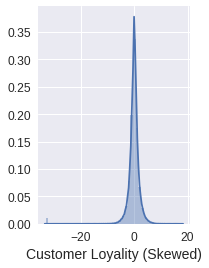

In [7]:
plt.subplot(1, 2, 2)
sns.distplot(train.target, kde=True, fit = norm)
plt.xlabel('Customer Loyality (Skewed)')

In [8]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [9]:
# Now extract the month, year, day, weekdayss
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['week'] = train["first_active_month"].dt.weekofyear
train['dayofweek'] = train['first_active_month'].dt.dayofweek
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
train['quarter'] = train['first_active_month'].dt.quarter
train['is_month_start'] = train['first_active_month'].dt.is_month_start

#Interaction Variables
train['days_feature1'] = train['days'] * train['feature_1']
train['days_feature2'] = train['days'] * train['feature_2']
train['days_feature3'] = train['days'] * train['feature_3']

train['days_feature1_ratio'] = train['feature_1'] / train['days']
train['days_feature2_ratio'] = train['feature_2'] / train['days']
train['days_feature3_ratio'] = train['feature_3'] / train['days']

train['feature_sum'] = train['feature_1'] + train['feature_2'] + train['feature_3']
train['feature_mean'] = train['feature_sum']/3
train['feature_max'] = train[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
train['feature_min'] = train[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
train['feature_var'] = train[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

test["month"] = test["first_active_month"].dt.month
test["year"] = test["first_active_month"].dt.year
test['week'] = test["first_active_month"].dt.weekofyear
test['dayofweek'] = test['first_active_month'].dt.dayofweek
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
test['quarter'] = test['first_active_month'].dt.quarter
test['is_month_start'] = test['first_active_month'].dt.is_month_start

#Interaction Variables
test['days_feature1'] = test['days'] * train['feature_1']
test['days_feature2'] = test['days'] * train['feature_2']
test['days_feature3'] = test['days'] * train['feature_3']

test['days_feature1_ratio'] = test['feature_1'] / train['days']
test['days_feature2_ratio'] = test['feature_2'] / train['days']
test['days_feature3_ratio'] = test['feature_3'] / train['days']

test['feature_sum'] = test['feature_1'] + test['feature_2'] + test['feature_3']
test['feature_mean'] = test['feature_sum']/3
test['feature_max'] = test[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
test['feature_min'] = test[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
test['feature_var'] = test[['feature_1', 'feature_2', 'feature_3']].std(axis=1)
gc.collect()

313

## Feature Engineering
Features from Transaction data

In [10]:
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_amount' : ['sum','max','min','mean','var','skew'],
        'installments' : ['sum','max','mean','var','skew'],
        'purchase_date' : ['max','min'],
        'month_lag' : ['max','min','mean','var','skew'],
        'month_diff' : ['max','min','mean','var','skew'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'card_id' : ['size','count'],
        'month': ['nunique', 'mean', 'min', 'max'],
        'hour': ['nunique', 'mean', 'min', 'max'],
        'weekofyear': ['nunique', 'mean', 'min', 'max'],
        'dayofweek': ['nunique', 'mean', 'min', 'max'],
        'year': ['nunique', 'mean', 'min', 'max'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'price' :['sum','mean','max','min','var'],
        'duration' : ['mean','min','max','var','skew'],
        'amount_month_ratio':['mean','min','max','var','skew']
        
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [11]:
transactions = reduce_mem_usage(pd.read_csv('../input/historical_transactions.csv'))
gc.collect()

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


0

In [12]:
#impute missing values (excluded)
transactions['category_2'] = transactions['category_2'].fillna(1.0,inplace=True)
transactions['category_3'] = transactions['category_3'].fillna('A',inplace=True)
transactions['merchant_id'] = transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
transactions['installments'].replace(-1, np.nan,inplace=True)
transactions['installments'].replace(999, np.nan,inplace=True)
transactions['purchase_amount'] = transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

#Feature Engineering - Adding new features inspired by Chau's first kernel
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})
transactions['category_3'] = transactions['category_3'].map({'A':0, 'B':1, 'C':2})

transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['is_month_start'] = transactions['purchase_date'].dt.is_month_start
transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

# additional features
transactions['duration'] = transactions['purchase_amount']*transactions['month_diff']
transactions['amount_month_ratio'] = transactions['purchase_amount']/transactions['month_diff']
transactions['price'] = transactions['purchase_amount'] / transactions['installments']

gc.collect()

230

In [13]:
agg_func = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
    transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
    transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
    transactions[col+'_sum'] = transactions['purchase_amount'].groupby(transactions[col]).agg('sum')
    agg_func[col+'_mean'] = ['mean']
    
gc.collect()

168

In [14]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()

63

In [15]:
#Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (datetime.datetime.today() - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
train['hist_last_buy'] = (train['hist_purchase_date_max'] - train['first_active_month']).dt.days

for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9
gc.collect()

110

In [16]:
#Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (datetime.datetime.today() - test['hist_purchase_date_min']).dt.days

test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
test['hist_last_buy'] = (test['hist_purchase_date_max'] - test['first_active_month']).dt.days

for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

gc.collect()

92

In [17]:
train.head(20)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,month,year,week,dayofweek,days,quarter,is_month_start,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_transactions_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,...,hist_month_max,hist_hour_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_dayofweek_nunique,hist_dayofweek_mean,hist_dayofweek_min,hist_dayofweek_max,hist_year_nunique,hist_year_mean,hist_year_min,hist_year_max,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,hist_first_buy,hist_last_buy
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820312,0,6,2017,22,3,245,2,True,3.220431,2.144270,2.799743,0.000054,0.000036,0.000047,0.033324,0.011108,0.013145,0.008752,0.002214,260,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,...,12,23,13.315385,0,23,35,33.073077,1,52,7,3.211538,0,6,2,2017.169231,2017,2018,21,41,NaN,NaN,inf,-inf,NaN,-7.613365,-8.872735,9.600000,2.952620,5.009202,-0.054526,-0.067081,0.066667,0.000150,4.877038,242,0.930769,359,601,26,269
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392822,0,1,2017,52,6,396,1,True,4.241790,4.508370,4.072003,0.000027,0.000029,0.000026,0.032379,0.010793,0.011385,0.010283,0.000555,350,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,...,12,24,14.717143,0,23,50,25.220000,1,52,7,3.362857,0,6,2,2017.145714,2017,2018,24,57,-202.218491,-0.581088,0.400000,-0.742400,0.060272,-7.913882,-9.651198,10.400000,9.758030,3.755794,-0.047894,-0.061741,0.061538,0.000356,3.660220,390,1.114286,383,773,5,395
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.687988,0,8,2016,31,0,549,3,True,5.824829,4.804915,5.645276,0.000019,0.000016,0.000019,0.029645,0.009882,0.010610,0.008752,0.000992,43,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,...,12,14,17.906977,8,23,22,18.372093,2,49,7,3.302326,0,6,2,2017.069767,2017,2018,7,8,-inf,-inf,-inf,-inf,NaN,-8.059234,-8.761658,-1.604321,1.217537,5.003119,-0.057136,-0.062499,-0.013259,0.000052,5.614270,412,9.581395,356,769,163,575
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142456,0,9,2017,35,4,153,3,True,1.638874,2.167460,1.573274,0.000070,0.000093,0.000067,0.035161,0.011720,0.014166,0.010283,0.002129,77,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,...,12,16,14.441558,0,23,20,32.012987,1,52,7,2.792208,0,6,2,2017.285714,2017,2018,13,25,-47.474445,-0.632993,0.800000,-0.740897,0.053342,-7.666420,-8.890766,9.600000,5.401047,5.775729,-0.055375,-0.067218,0.066667,0.000282,5.434693,154,2.000000,355,510,25,180
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159790,0,11,2017,44,2,92,4,True,0.741381,1.303309,0.946021,0.000088,0.000154,0.000112,0.032508,0.010836,0.014166,0.008058,0.003091,133,-75.245931,0.800000,-0.746156,-0.565759,0.103889,3.267681,182.0,12.0,1.368421,3.598086,5.419892,1.519850

In [18]:
def aggregate_transaction_new(trans, prefix):  
        
    agg_func = {
        'purchase_amount' : ['sum','max','min','mean','var','skew'],
        'installments' : ['sum','max','mean','var','skew'],
        'purchase_date' : ['max','min'],
        'month_lag' : ['max','min','mean','var','skew'],
        'month_diff' : ['max','min','mean','var','skew'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'card_id' : ['size','count'],
        'month': ['nunique', 'mean', 'min', 'max'],
        'hour': ['nunique', 'mean', 'min', 'max'],
        'weekofyear': ['nunique', 'mean', 'min', 'max'],
        'dayofweek': ['nunique', 'mean', 'min', 'max'],
        'year': ['nunique', 'mean', 'min', 'max'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'price' :['sum','mean','max','min','var'],
        'duration' : ['mean','min','max','var','skew'],
        'amount_month_ratio':['mean','min','max','var','skew']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [19]:
new_transactions = reduce_mem_usage(pd.read_csv('../input/new_merchant_transactions.csv'))

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [20]:
#impute missing values
new_transactions['category_2'] = new_transactions['category_2'].fillna(1.0,inplace=True)
new_transactions['category_3'] = new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
new_transactions['installments'].replace(-1, np.nan,inplace=True)
new_transactions['installments'].replace(999, np.nan,inplace=True)
new_transactions['purchase_amount'] = new_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

#Adding new features inspired by Chau's first kernel
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})
new_transactions['category_3'] = new_transactions['category_3'].map({'A':0, 'B':1, 'C':2}) 

new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['quarter'] = new_transactions['purchase_date'].dt.quarter
new_transactions['is_month_start'] = new_transactions['purchase_date'].dt.is_month_start
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

gc.collect()

# additional features
new_transactions['duration'] = new_transactions['purchase_amount']*new_transactions['month_diff']
new_transactions['amount_month_ratio'] = new_transactions['purchase_amount']/new_transactions['month_diff']
new_transactions['price'] = new_transactions['purchase_amount'] / new_transactions['installments']

aggs = {
        'mean': ['mean'],
    }

for col in ['category_2','category_3']:
    new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('mean')
    new_transactions[col+'_max'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('max')
    new_transactions[col+'_min'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('min')
    new_transactions[col+'_var'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('var')
    aggs[col+'_mean'] = ['mean']

gc.collect()

189

In [21]:
merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
del merge_new

gc.collect()

28

In [22]:
#Adding new features inspired by Chau's first kernel
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (datetime.datetime.today() - train['new_purchase_date_max']).dt.days
train['new_purchase_date_uptomin'] = (datetime.datetime.today() - train['new_purchase_date_min']).dt.days
train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
train['new_last_buy'] = (train['new_purchase_date_max'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Adding new features inspired by Chau's first kernel
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (datetime.datetime.today() - test['new_purchase_date_max']).dt.days
test['new_purchase_date_uptomin'] = (datetime.datetime.today() - test['new_purchase_date_min']).dt.days
test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
test['new_last_buy'] = (test['new_purchase_date_max'] - test['first_active_month']).dt.days

for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
gc.collect()

184

In [23]:
#new features referred from https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending
train['card_id_total'] = train['new_card_id_size']+train['hist_card_id_size']
train['card_id_cnt_total'] = train['new_card_id_count']+train['hist_card_id_count']
train['card_id_cnt_ratio'] = train['new_card_id_count']/train['hist_card_id_count']
train['purchase_amount_total'] = train['new_purchase_amount_sum']+train['hist_purchase_amount_sum']
train['purchase_amount_mean'] = train['new_purchase_amount_mean']+train['hist_purchase_amount_mean']
train['purchase_amount_max'] = train['new_purchase_amount_max']+train['hist_purchase_amount_max']
train['purchase_amount_min'] = train['new_purchase_amount_min']+train['hist_purchase_amount_min']
train['purchase_amount_ratio'] = train['new_purchase_amount_sum']/train['hist_purchase_amount_sum']
train['month_diff_mean'] = train['new_month_diff_mean']+train['hist_month_diff_mean']
train['month_diff_ratio'] = train['new_month_diff_mean']/train['hist_month_diff_mean']
train['month_lag_mean'] = train['new_month_lag_mean']+train['hist_month_lag_mean']
train['month_lag_max'] = train['new_month_lag_max']+train['hist_month_lag_max']
train['month_lag_min'] = train['new_month_lag_min']+train['hist_month_lag_min']
train['category_1_mean'] = train['new_category_1_mean']+train['hist_category_1_mean']
train['installments_total'] = train['new_installments_sum']+train['hist_installments_sum']
train['installments_mean'] = train['new_installments_mean']+train['hist_installments_mean']
train['installments_max'] = train['new_installments_max']+train['hist_installments_max']
train['installments_ratio'] = train['new_installments_sum']/train['hist_installments_sum']
train['price_total'] = train['purchase_amount_total'] / train['installments_total']
train['price_mean'] = train['purchase_amount_mean'] / train['installments_mean']
train['price_max'] = train['purchase_amount_max'] / train['installments_max']
train['duration_mean'] = train['new_duration_mean']+train['hist_duration_mean']
train['duration_min'] = train['new_duration_min']+train['hist_duration_min']
train['duration_max'] = train['new_duration_max']+train['hist_duration_max']
train['amount_month_ratio_mean']=train['new_amount_month_ratio_mean']+train['hist_amount_month_ratio_mean']
train['amount_month_ratio_min']=train['new_amount_month_ratio_min']+train['hist_amount_month_ratio_min']
train['amount_month_ratio_max']=train['new_amount_month_ratio_max']+train['hist_amount_month_ratio_max']
train['new_CLV'] = train['new_card_id_count'] * train['new_purchase_amount_sum'] / train['new_month_diff_mean']
train['hist_CLV'] = train['hist_card_id_count'] * train['hist_purchase_amount_sum'] / train['hist_month_diff_mean']
train['CLV_ratio'] = train['new_CLV'] / train['hist_CLV']

test['card_id_total'] = test['new_card_id_size']+test['hist_card_id_size']
test['card_id_cnt_total'] = test['new_card_id_count']+test['hist_card_id_count']
test['card_id_cnt_ratio'] = test['new_card_id_count']/test['hist_card_id_count']
test['purchase_amount_total'] = test['new_purchase_amount_sum']+test['hist_purchase_amount_sum']
test['purchase_amount_mean'] = test['new_purchase_amount_mean']+test['hist_purchase_amount_mean']
test['purchase_amount_max'] = test['new_purchase_amount_max']+test['hist_purchase_amount_max']
test['purchase_amount_min'] = test['new_purchase_amount_min']+test['hist_purchase_amount_min']
test['purchase_amount_ratio'] = test['new_purchase_amount_sum']/test['hist_purchase_amount_sum']
test['month_diff_mean'] = test['new_month_diff_mean']+test['hist_month_diff_mean']
test['month_diff_ratio'] = test['new_month_diff_mean']/test['hist_month_diff_mean']
test['month_lag_mean'] = test['new_month_lag_mean']+test['hist_month_lag_mean']
test['month_lag_max'] = test['new_month_lag_max']+test['hist_month_lag_max']
test['month_lag_min'] = test['new_month_lag_min']+test['hist_month_lag_min']
test['category_1_mean'] = test['new_category_1_mean']+test['hist_category_1_mean']
test['installments_total'] = test['new_installments_sum']+test['hist_installments_sum']
test['installments_mean'] = test['new_installments_mean']+test['hist_installments_mean']
test['installments_max'] = test['new_installments_max']+test['hist_installments_max']
test['installments_ratio'] = test['new_installments_sum']/test['hist_installments_sum']
test['price_total'] = test['purchase_amount_total'] / test['installments_total']
test['price_mean'] = test['purchase_amount_mean'] / test['installments_mean']
test['price_max'] = test['purchase_amount_max'] / test['installments_max']
test['duration_mean'] = test['new_duration_mean']+test['hist_duration_mean']
test['duration_min'] = test['new_duration_min']+test['hist_duration_min']
test['duration_max'] = test['new_duration_max']+test['hist_duration_max']
test['amount_month_ratio_mean']=test['new_amount_month_ratio_mean']+test['hist_amount_month_ratio_mean']
test['amount_month_ratio_min']=test['new_amount_month_ratio_min']+test['hist_amount_month_ratio_min']
test['amount_month_ratio_max']=test['new_amount_month_ratio_max']+test['hist_amount_month_ratio_max']
test['new_CLV'] = test['new_card_id_count'] * test['new_purchase_amount_sum'] / test['new_month_diff_mean']
test['hist_CLV'] = test['hist_card_id_count'] * test['hist_purchase_amount_sum'] / test['hist_month_diff_mean']
test['CLV_ratio'] = test['new_CLV'] / test['hist_CLV']

In [24]:
train.head(20)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,month,year,week,dayofweek,days,quarter,is_month_start,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_transactions_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,...,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820312,0,6,2017,22,3,245,2,True,3.220431,2.144270,2.799743,0.000054,0.000036,0.000047,0.033324,0.011108,0.013145,0.008752,0.002214,260,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,...,-0.065874,-0.024679,1.393057e-04,0.775508,54.0,2.347826,296.0,350.0,277.0,332.0,283.0,283.0,0.088462,-180.671030,-1.219772,0.503857,-1.464004,0.079102,23.522575,0.988901,-2.433278,2.0,-7.0,0.000000,4.0,0.015385,1.0,0.000000,-45.167758,-79.285187,0.503857,-14.349725,-17.509453,6.342432,-0.103826,-0.132955,0.041988,-26.044689,-3680.674553,0.007076
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392822,0,1,2017,52,6,396,1,True,4.241790,4.508370,4.072003,0.000027,0.000029,0.000026,0.032379,0.010793,0.011385,0.010283,0.000555,350,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,...,-0.058472,-0.055026,1.239274e-06,-0.617956,56.0,9.333333,326.0,382.0,396.0,453.0,356.0,356.0,0.017143,-219.750464,-1.341326,0.098340,-1.481658,0.020221,25.701905,0.997262,-3.531429,2.0,-11.0,0.088571,551.0,2.566092,11.0,0.011009,-0.398821,-0.522711,0.008940,-17.233787,-19.261549,1.980078,-0.104483,-0.120213,0.006513,-2.036323,-5858.323020,0.000348
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.687988,0,8,2016,31,0,549,3,True,5.824829,4.804915,5.645276,0.000019,0.000016,0.000019,0.029645,0.009882,0.010610,0.008752,0.000992,43,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,...,-0.063654,-0.063654,NaN,NaN,0.0,0.000000,296.0,296.0,635.0,635.0,44.0,44.0,0.023256,-29.867586,-1.378507,-0.846043,-1.430333,0.024006,22.860465,0.927451,-6.604651,2.0,-11.0,0.000000,0.0,0.000000,0.0,NaN,-inf,-inf,-inf,-15.761382,-16.463807,-9.306469,-0.120790,-0.126153,-0.076913,-0.063654,-105.746091,0.000602
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142456,0,9,2017,35,4,153,3,True,1.638874,2.167460,1.573274,0.000070,0.000093,0.000067,0.035161,0.011720,0.014166,0.010283,0.002129,77,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,...,-0.061198,-0.047241,3.016184e-05,0.804093,41.0,5.857143,307.0,348.0,187.0,229.0,84.0,84.0,0.090909,-54.791745,-1.316099,0.233105,-1.475272,0.092841,23.792208,1.017621,-1.116883,2.0,-4.0,0.298701,92.0,2.146667,4.0,0.069767,-0.595562,-0.613089,0.058276,-15.646052,-17.703266,2.797266,-0.110790,-0.128416,0.019425,-2.715291,-327.381095,0.008

In [25]:
train = train.drop(['card_id', 'first_active_month'], axis = 1)
test = test.drop(['card_id', 'first_active_month'], axis = 1)

In [26]:
# X and Y
df_train_columns = [c for c in train.columns if c not in ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size']] 
target = train['target']
del train['target']

# LGBM Model
Stratified K Folds enumerated on training set and outliers

In [27]:
# Change in Hyper Parameters using kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
import lightgbm as lgb

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train['outliers'].values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': -1,
                'top_rate': 0.9064148448434349,
                'num_leaves': 31,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 0.1,
                'min_data_in_leaf': 32,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':2015,
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))


fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1487]	training's rmse: 3.30447	valid_1's rmse: 3.65588
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1376]	training's rmse: 3.31648	valid_1's rmse: 3.66481
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[530]	training's rmse: 3.47073	valid_1's rmse: 3.65089
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1160]	training's rmse: 3.35308	valid_1's rmse: 3.65045
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1580]	training's rmse: 3.29155	valid_1's rmse: 3.6585


3.6561087059665005

In [28]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 3.65611 


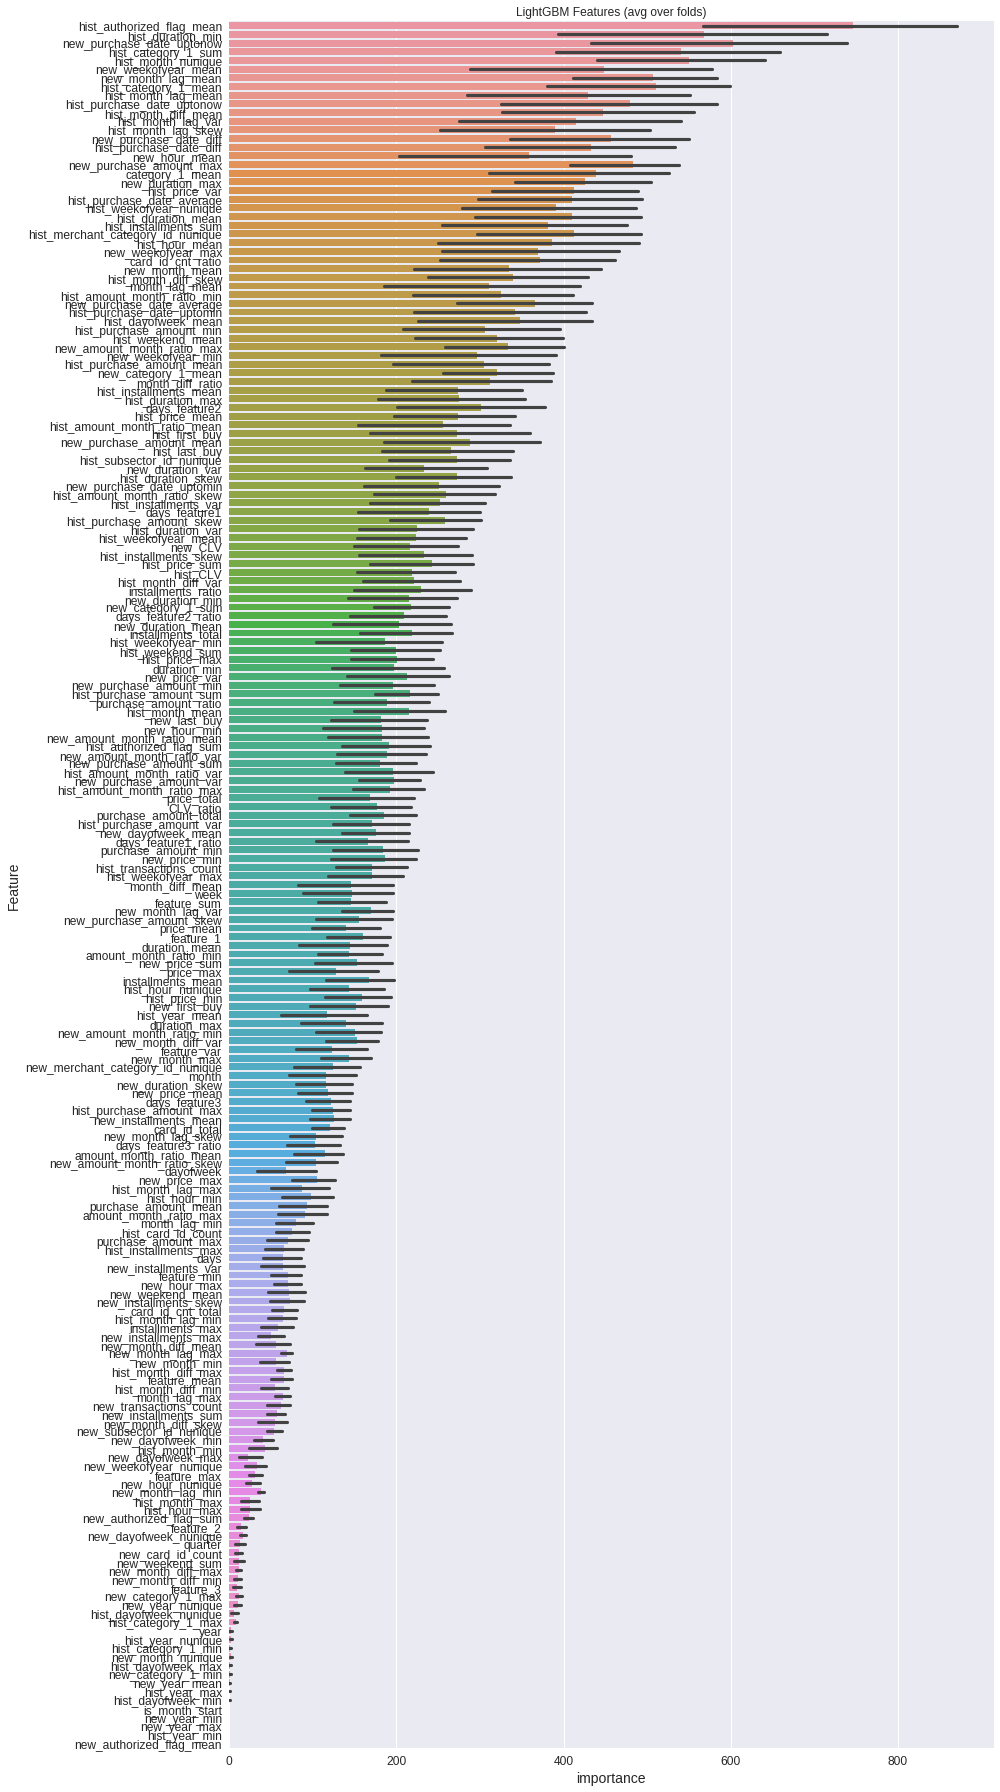

In [29]:
# Feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [30]:
features = [c for c in train.columns if c not in ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size']]

LGBM - Repeated K Folds enumerated on training set and Target

In [31]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2019)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.75836372582243783,
                'subsample': 0.91158142068248083,
                'max_depth': 29,
                'top_rate': 0.7790255922489042,
                'num_leaves': 562,
                'min_child_weight': 27,
                'other_rate': 0.03564199289369395,
                'reg_alpha': 0.72876375065913579,
                'colsample_bytree': 0.83435723889734326,
                'min_split_gain': 27.378180277455101,
                'reg_lambda': 94.549009291544877,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':20190208,
                'bagging_seed':20190208,
                'drop_seed':20190208
                }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[features], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 3.48778	valid_1's rmse: 3.77903
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 3.50265	valid_1's rmse: 3.7255
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.65638	valid_1's rmse: 3.63301
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 3.47126	valid_1's rmse: 3.84705
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.65005	valid_1's rmse: 3.65317
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.61652	valid_1's rmse: 3.76279
fold 6
Training until validation scores don't improve

Feature importance - Repeated K Folds

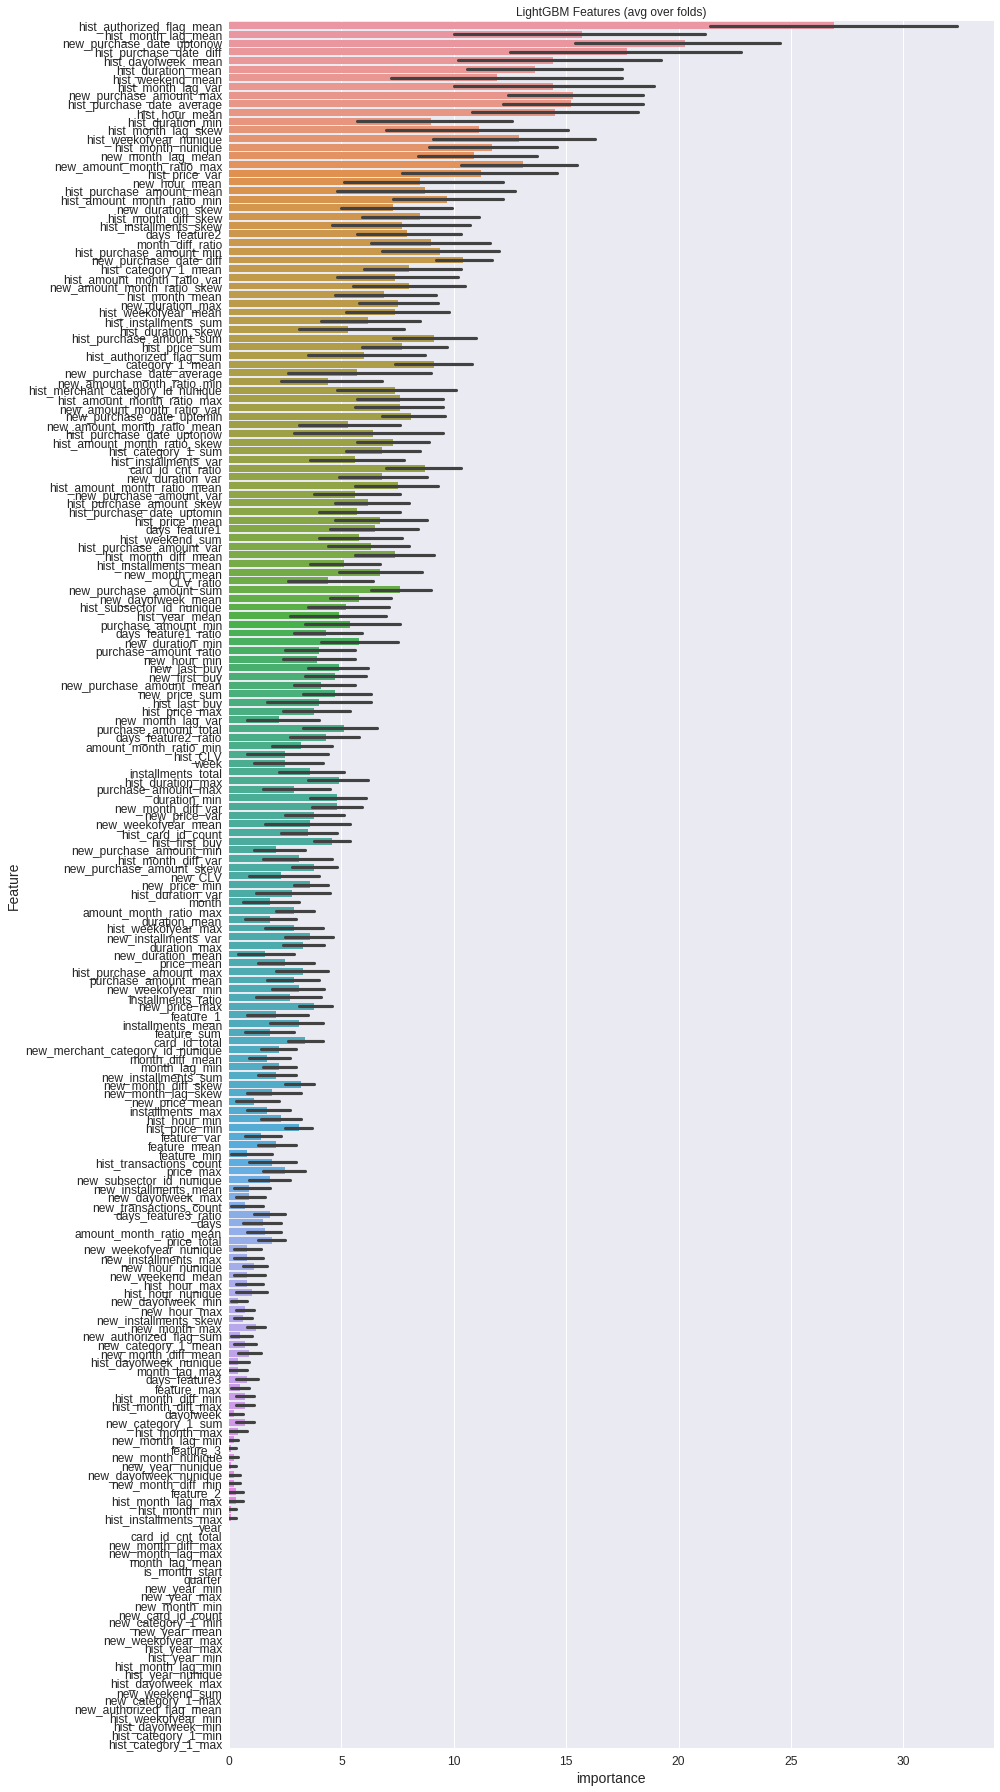

In [32]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

#### Stacking

In [33]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4


3.6551046505394815

In [34]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions_3
sample_submission.to_csv('submission.csv', index=False)

In [35]:
sample_submission['target'] = (predictions * 0.125+ predictions_2*0.5+predictions_3*0.325)*1.1
sample_submission.to_csv("sub_2.csv", index = False)